# "zero-enrichment" peptides within group controls.

    1. How do the peptides with zero counts correlate between library controls within each group?

In [8]:
import phippery
from phippery.normalize import *
from phippery.utils import *
import xarray as xr
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from functools import reduce
from plotnine import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
data_path = "../Caitlin-CoV2-PhIP-Seq-Analysis/pipeline-run-09-03-20/09-03-20-cov.phip"

In [10]:
ds = pickle.load(open(data_path, "rb"))

[96, 321, 273, 434, 340]
0.7504160756025401
[96, 273, 434, 340]


NameError: name 'tidy_ds' is not defined

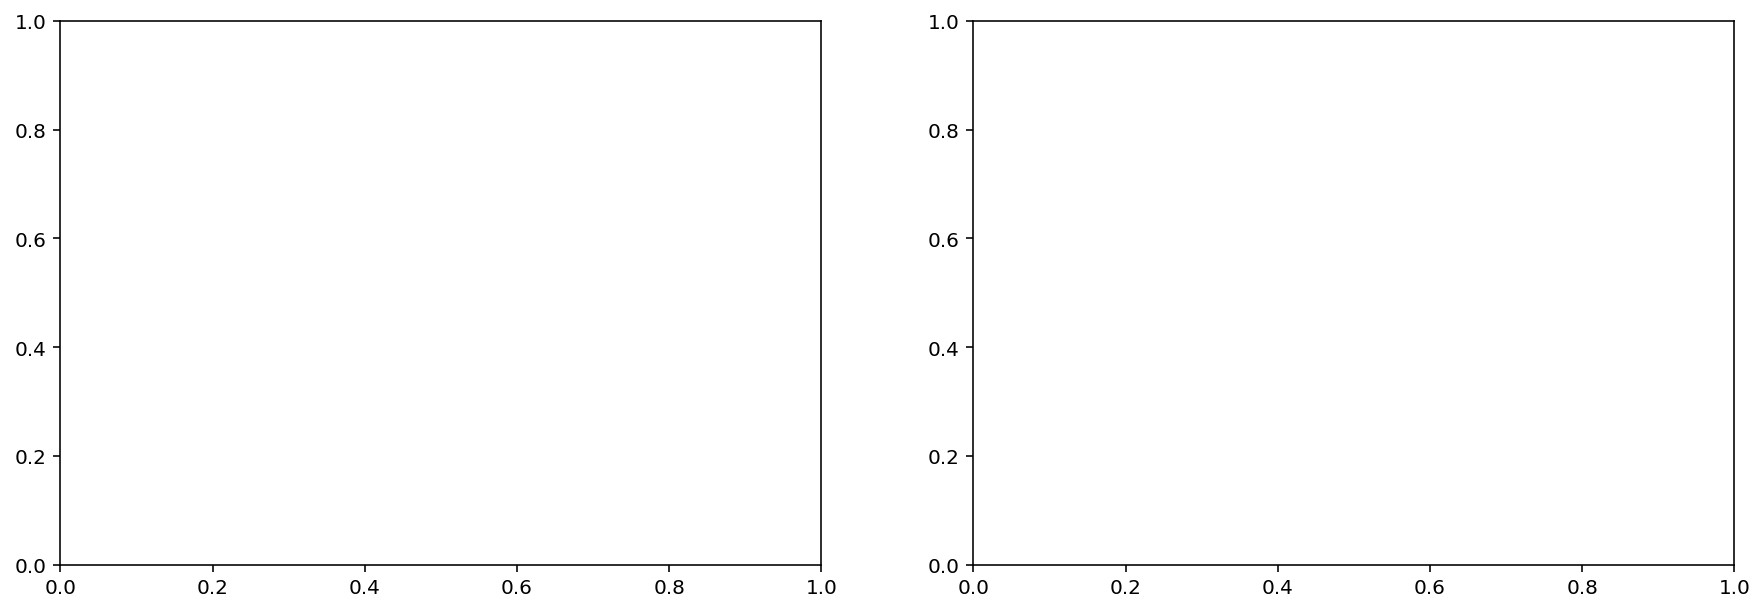

In [11]:
from venn import venn
fig, ax = plt.subplots(1, 2, figsize=[15,5])
library_batches = ["MEGSUB","SUB2"]
for i, library in enumerate(library_batches):

    # a set of all sample id's wrt the chosen library batch.
    batch_samples = set(
            sample_id_coordinate_subset(
                ds, where="library_batch", is_equal_to=library
            )
    )
    # find all hq batch-specific library controls
    library_controls = set(
            sample_id_coordinate_subset(ds, where="control_status", is_equal_to="library")
    )
    
    batch_library_controls = list(set.intersection(batch_samples, library_controls))
    
    #batch_lib_counts = counts.loc[:,batch_lib_control]
    #zero_pep[batch_lib_control] = set(batch_lib_counts[batch_lib_counts == 0].index.values)
    #print(f" lib control id {batch_lib_control} has {len(batch_lib_counts[batch_lib_counts == 0])} zero peptides")
    
    library_ds = ds.loc[dict(sample_id=batch_library_controls)]
    print(batch_library_controls)
    assert len(batch_library_controls) > 0
    library_cc_df = library_ds.counts.to_pandas().corr()
    print(np.mean(library_cc_df.values.flatten()))
    batch_library_controls = [
        sid for sid, cc in library_cc_df.iterrows()
        if (sum(cc)-1)/(len(library_cc_df)-1) >= 0.5
    ]
    print(batch_library_controls)
    library_ds = ds.loc[dict(sample_id=batch_library_controls)]
    tidy_lib = tidy_ds(library_ds)
    ax[i].hist(tidy_lib.counts.values.flatten(), bins=100)
    #continue


plt.show()

In [24]:
counts = xpds.counts.to_pandas()
zero_pep = {}
for batch_lib_control in list(set.intersection(batch_samples, library_controls)):
    batch_lib_counts = counts.loc[:,batch_lib_control]
    zero_pep[batch_lib_control] = set(batch_lib_counts[batch_lib_counts == 0].index.values)
    print(f" lib control id {batch_lib_control} has {len(batch_lib_counts[batch_lib_counts == 0])} zero peptides")

 lib control id 192 has 4256 zero peptides
 lib control id 388 has 239 zero peptides
 lib control id 48 has 7537 zero peptides
 lib control id 144 has 1141 zero peptides
 lib control id 338 has 634 zero peptides
 lib control id 247 has 203 zero peptides
 lib control id 472 has 266 zero peptides
 lib control id 220 has 2106 zero peptides


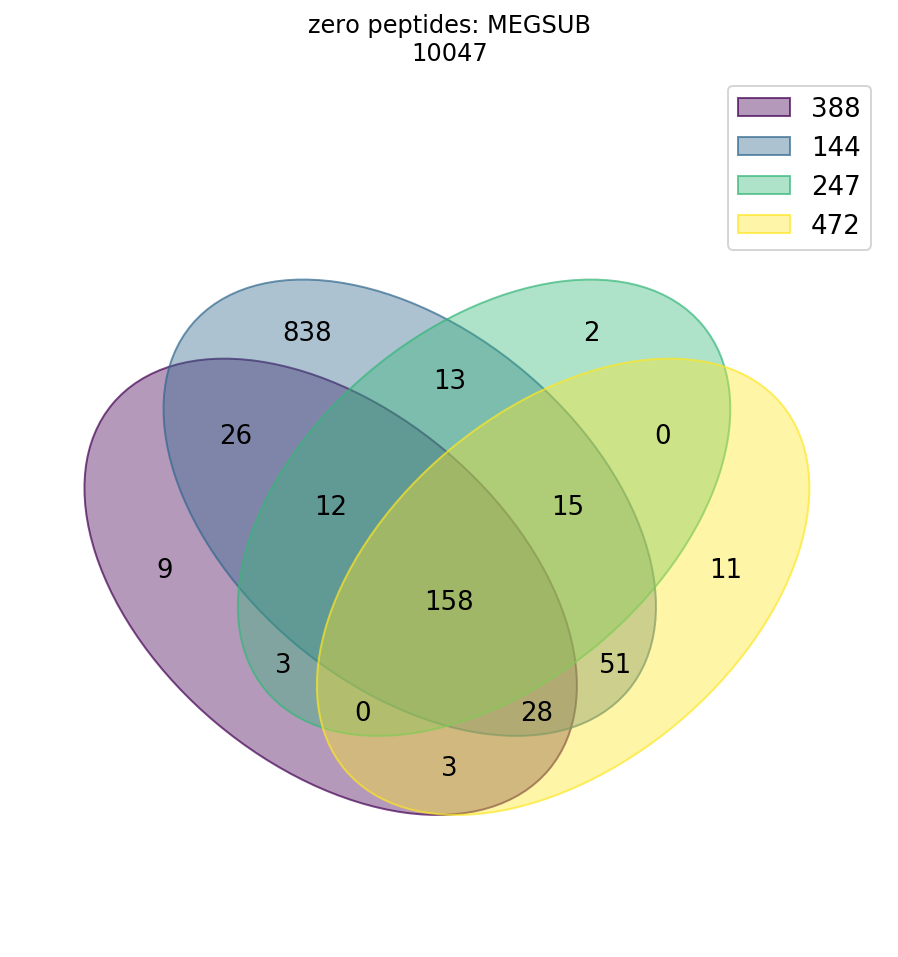

In [37]:
from venn import venn
fig, ax = plt.subplots(1, figsize=[8,8])
#del zero_pep[321]
venn(zero_pep, ax=ax)
ax.set_title(f"zero peptides: MEGSUB\n{len(xpds.peptide_id.values)}")
plt.show()
fig.savefig("Zero-Peptides: MEGSUB")

In [38]:
def get_high_quality_controls(
    xpds, 
    library_batch, 
    tech_rep_cc_thresh = -0.1,
    control_pw_cc_thresh = 0.5, 
    contol_status_column = "control_status",
    beads_factor="beads_only",
    library_factor="library",
    batch_column="library_batch"
):
    """a function which will curate the technical replicates below
    some threshold, then compute standardized enrichment in terms 
    of a specific library batch"""

    batch_samples = set(sample_id_subset(xpds, where="library_batch", is_equal_to=library_batch))
    samples_above_tech_thresh = set(xpds.sample_id.where(
        xpds.sample_table.loc[:, "tech_rep_correlation"] >= tech_rep_cc_thresh, drop=True
    ).sample_id.values)
    beads_controls = set(sample_id_subset(xpds, where="control_status", is_equal_to="beads_only"))
    library_controls = set(sample_id_subset(xpds, where="control_status", is_equal_to="library"))
    batch_beads_controls = list(set.intersection(batch_samples, beads_controls, samples_above_tech_thresh))
    batch_lib_controls = list(set.intersection(batch_samples, library_controls, samples_above_tech_thresh))
    beads_ds = xpds.loc[dict(sample_id=batch_beads_controls)]
    lib_ds = xpds.loc[dict(sample_id=batch_lib_controls)]
    
    assert len(batch_beads_controls) > 0
    assert len(batch_lib_controls) > 0
    
    beads_cc_df = beads_ds.counts.to_pandas().corr()
    batch_beads_controls = [
        sid for sid, cc in beads_cc_df.iterrows() 
        if (sum(cc)-1)/(len(beads_cc_df)-1) >= control_pw_cc_thresh
    ] 
    lib_cc_df = lib_ds.counts.to_pandas().corr()
    batch_lib_controls = [
        sid for sid, cc in lib_cc_df.iterrows() 
        if (sum(cc)-1)/(len(lib_cc_df)-1) >= control_pw_cc_thresh
    ]
    
    return batch_beads_controls, batch_lib_controls

In [39]:
high_quality_lib_controls_1 = get_high_quality_controls(xpds, batch_1)[1] 

In [40]:
zero_pep = {}
for batch_lib_control in high_quality_lib_controls_1:
    batch_lib_counts = counts.loc[:,batch_lib_control]
    zero_pep[batch_lib_control] = set(batch_lib_counts[batch_lib_counts == 0].index.values)
    print(f" lib control id {batch_lib_control} has {len(batch_lib_counts[batch_lib_counts == 0])} zero peptides")

 lib control id 96 has 206 zero peptides
 lib control id 273 has 284 zero peptides
 lib control id 434 has 290 zero peptides
 lib control id 340 has 254 zero peptides


Mean number of reads per phage:90.2227530606151
Meadian number of reads per phage:39.0


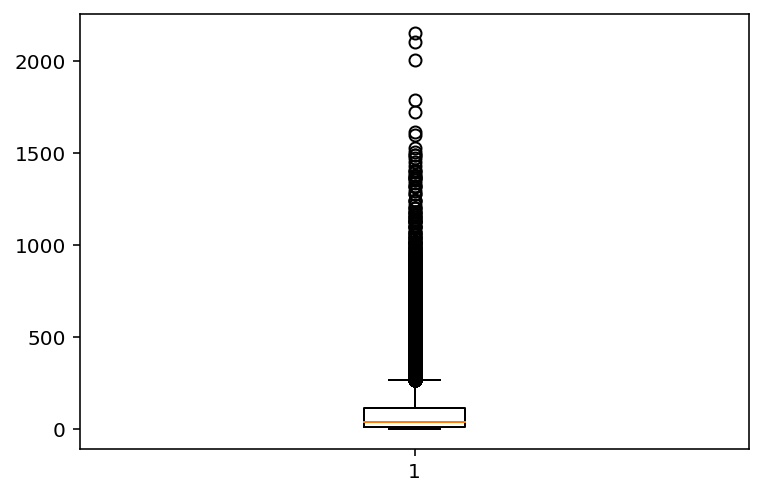

In [48]:
phage_reads = counts.loc[:,zero_pep.keys()].values.flatten()
print(f"Mean number of reads per phage:{phage_reads.mean()}")
print(f"Meadian number of reads per phage:{np.median(phage_reads)}")
plt.boxplot(phage_reads)
#plt.xlim([0,600])
plt.show()

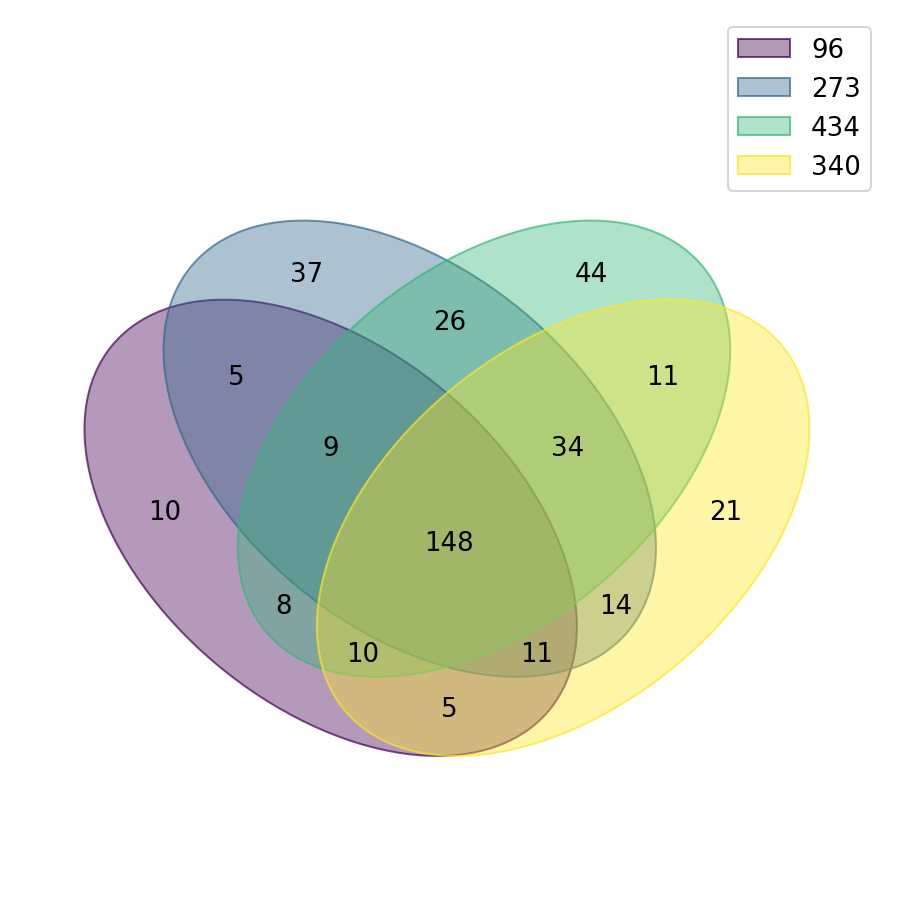

In [42]:
from venn import venn
venn(zero_pep)
plt.show()

In [43]:
high_quality_lib_controls_2 = get_high_quality_controls(xpds, batch_2, control_pw_cc_thresh = 0.7)[1] 

In [44]:
zero_pep = {}
for batch_lib_control in high_quality_lib_controls_2:
    batch_lib_counts = counts.loc[:,batch_lib_control]
    zero_pep[batch_lib_control] = set(batch_lib_counts[batch_lib_counts == 0].index.values)
    print(f" lib control id {batch_lib_control} has {len(batch_lib_counts[batch_lib_counts == 0])} zero peptides")

 lib control id 388 has 239 zero peptides
 lib control id 144 has 1141 zero peptides
 lib control id 247 has 203 zero peptides
 lib control id 472 has 266 zero peptides


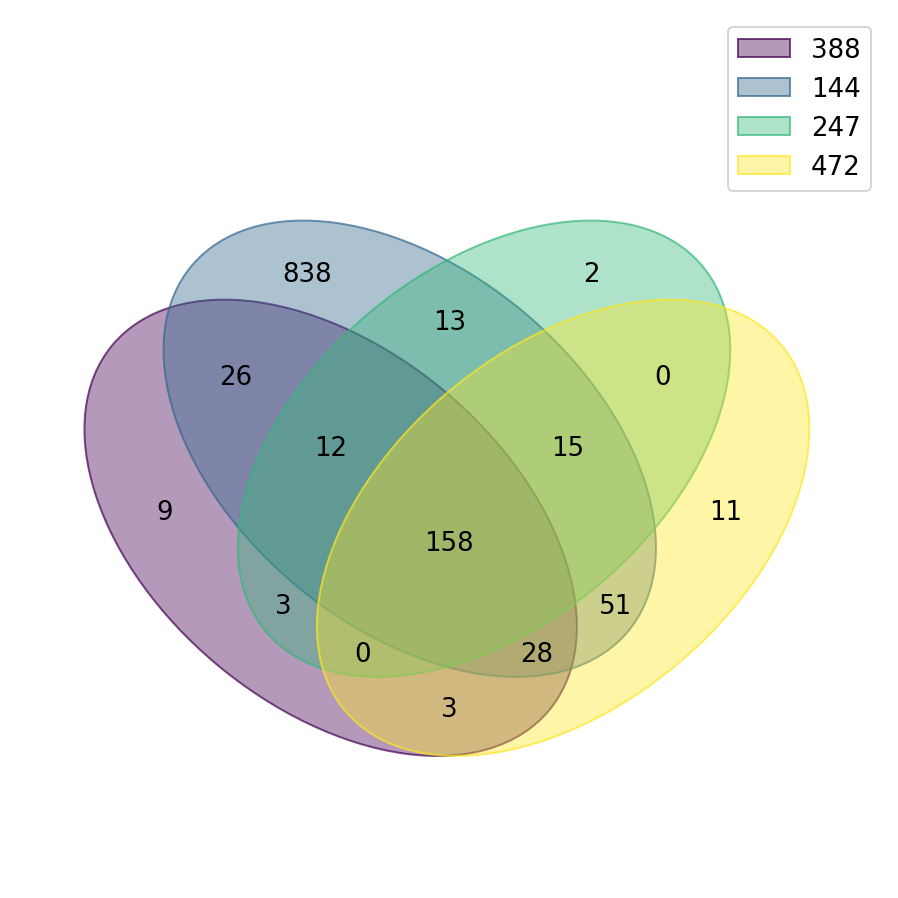

In [45]:
from venn import venn
venn(zero_pep)
plt.show()

## GC analysis of high/low count peptides.

In [103]:
def get_high_quality_controls(
    xpds, 
    library_batch, 
    control_pw_cc_thresh = 0.5, 
    control_status_column = "control_status",
    library_factor="library",
    batch_column="library_batch"
):
    """a function which will curate the technical replicates below
    some threshold, then compute standardized enrichment in terms 
    of a specific library batch"""

    batch_samples = set(sample_id_subset(xpds, where=batch_column, is_equal_to=library_batch))
    library_controls = set(sample_id_subset(xpds, where=control_status_column, is_equal_to=library_factor))
    batch_lib_controls = list(set.intersection(batch_samples, library_controls))
    lib_ds = xpds.loc[dict(sample_id=batch_lib_controls)]
    
    assert len(batch_lib_controls) > 0
    
    lib_cc_df = lib_ds.counts.to_pandas().corr()
    batch_lib_controls = [
        sid for sid, cc in lib_cc_df.iterrows() 
        if (sum(cc)-1)/(len(lib_cc_df)-1) >= control_pw_cc_thresh
    ]
    
    return batch_lib_controls


def shared_zero_count_peptides(ds, samples):
    """return a list of peptides where all samples share a zero count for that peptide"""
    
    zero_pep = []
    counts = ds.loc[dict(sample_id=samples)].counts.to_pandas()
    for batch_lib_control in samples:
        batch_lib_counts = counts.loc[:,batch_lib_control]
        zero_pep.append(set(batch_lib_counts[batch_lib_counts == 0].index.values))
    
    return list(set.intersection(*zero_pep))

In [114]:
lib_ds_megsub = xpds.loc[dict(sample_id=high_quality_lib_megsub)]
gc_content, avg_count = [],[]
for pep_id in lib_ds_megsub.peptide_id:
    avg_count.append(lib_ds_megsub.counts.loc[pep_id,:].values.mean())
    sequence = "".join([n for n in str(lib_ds_megsub.peptide_table.loc[pep_id,"Oligo"].values) if n.isupper()])
    gc_content.append((sequence.count("G") + sequence.count("C")) / len(sequence))

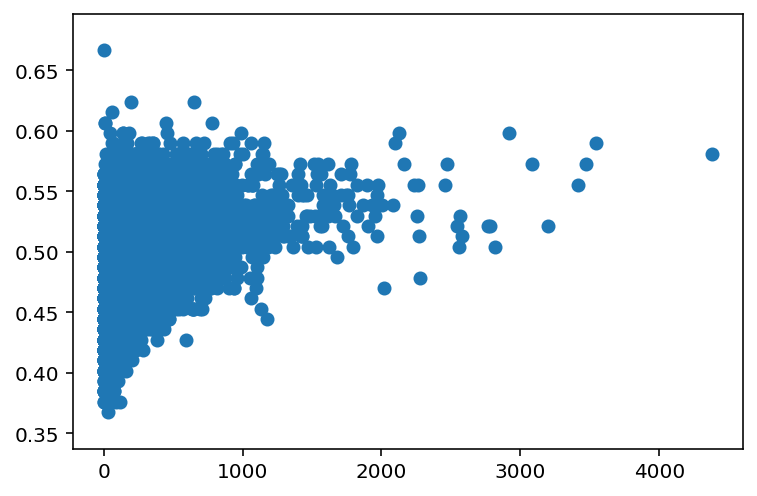

In [115]:
fig, ax = plt.subplots(1)
ax.scatter(avg_count, gc_content)
plt.show()

In [116]:
zero_pep_gc = []
for pep_id in zero_count_peptides_megsub:
    sequence = "".join([n for n in str(lib_ds_megsub.peptide_table.loc[pep_id,"Oligo"].values) if n.isupper()])
    zero_pep_gc.append((sequence.count("G") + sequence.count("C")) / len(sequence))

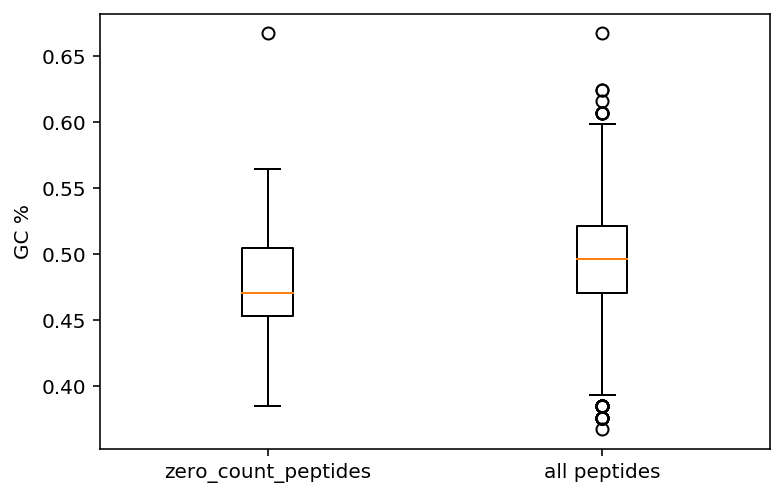

In [118]:
plt.boxplot([zero_pep_gc, gc_content], labels=["zero_count_peptides", "all peptides"])
plt.ylabel("GC %")
plt.show()

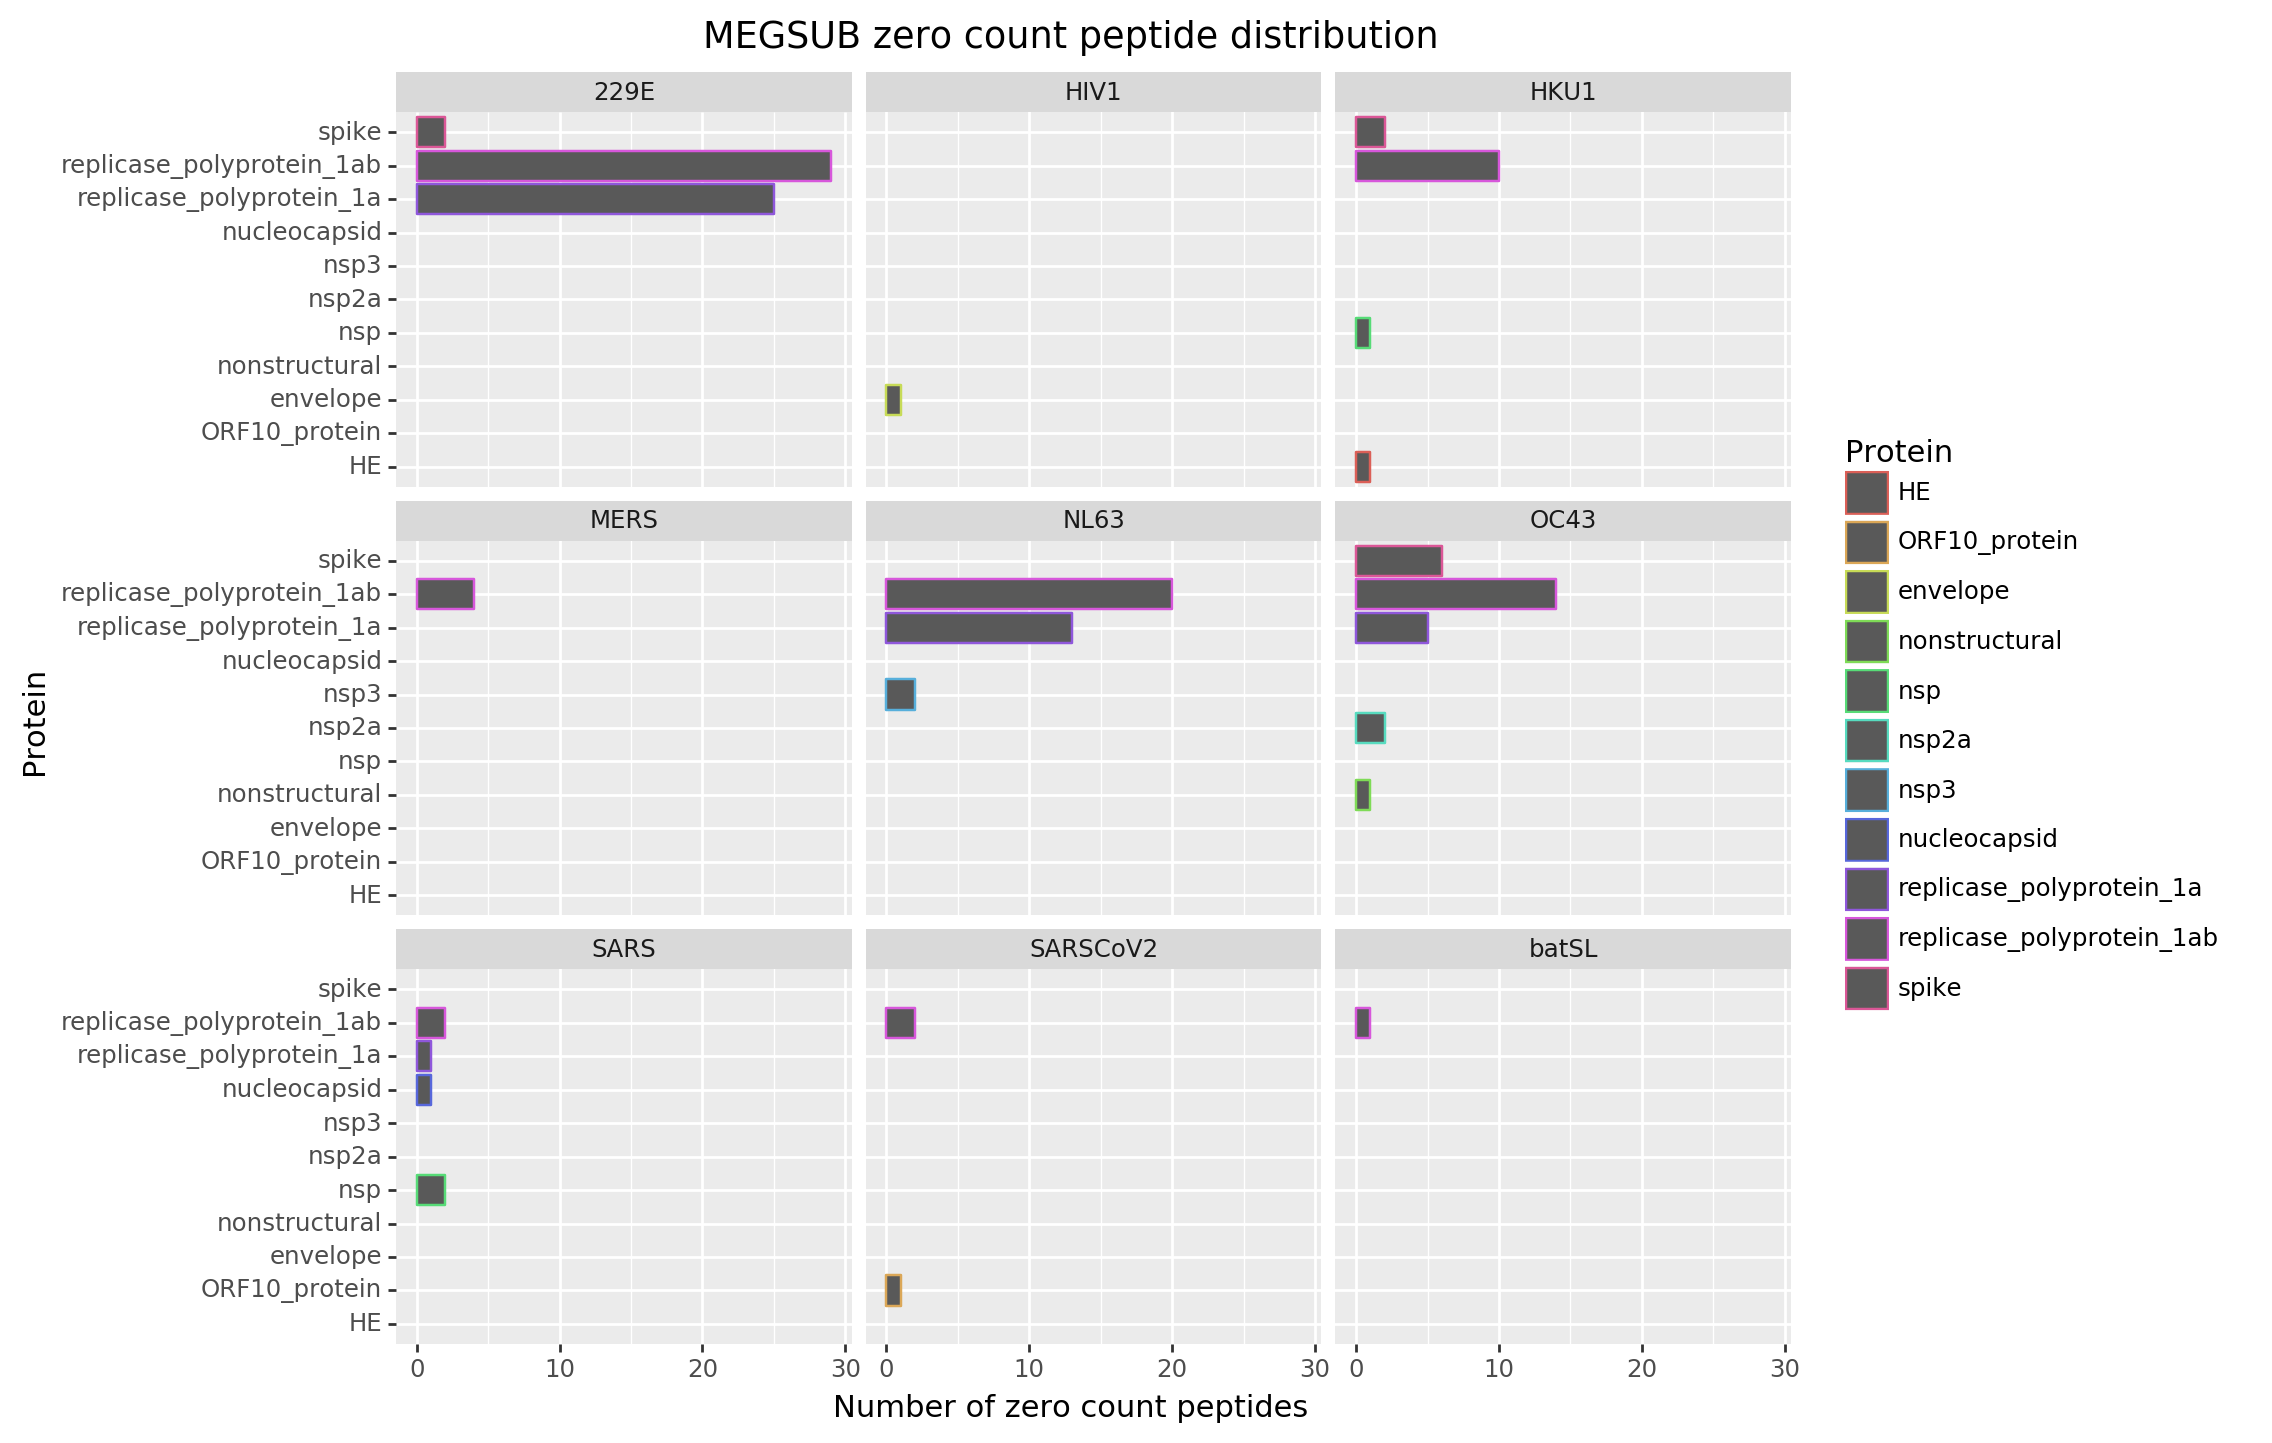

<ggplot: (-9223363249613747866)>

In [121]:
high_quality_lib_megsub = get_high_quality_controls(xpds, "MEGSUB")
zero_count_peptides_megsub = shared_zero_count_peptides(xpds, high_quality_lib_megsub)
zero_count_peptides_megsub_df = xpds.peptide_table.loc[zero_count_peptides_megsub,:].to_pandas()
(
    ggplot(zero_count_peptides_megsub_df)
    + geom_bar(aes(x='Protein', color="Protein"))
    + coord_flip()
    + theme(figure_size=[9,8])
    #+ theme_classic()
    + facet_wrap('~Virus')
    + labs(
     title=f"MEGSUB zero count peptide distribution",
     y="Number of zero count peptides",
     x="Protein"
    )
)

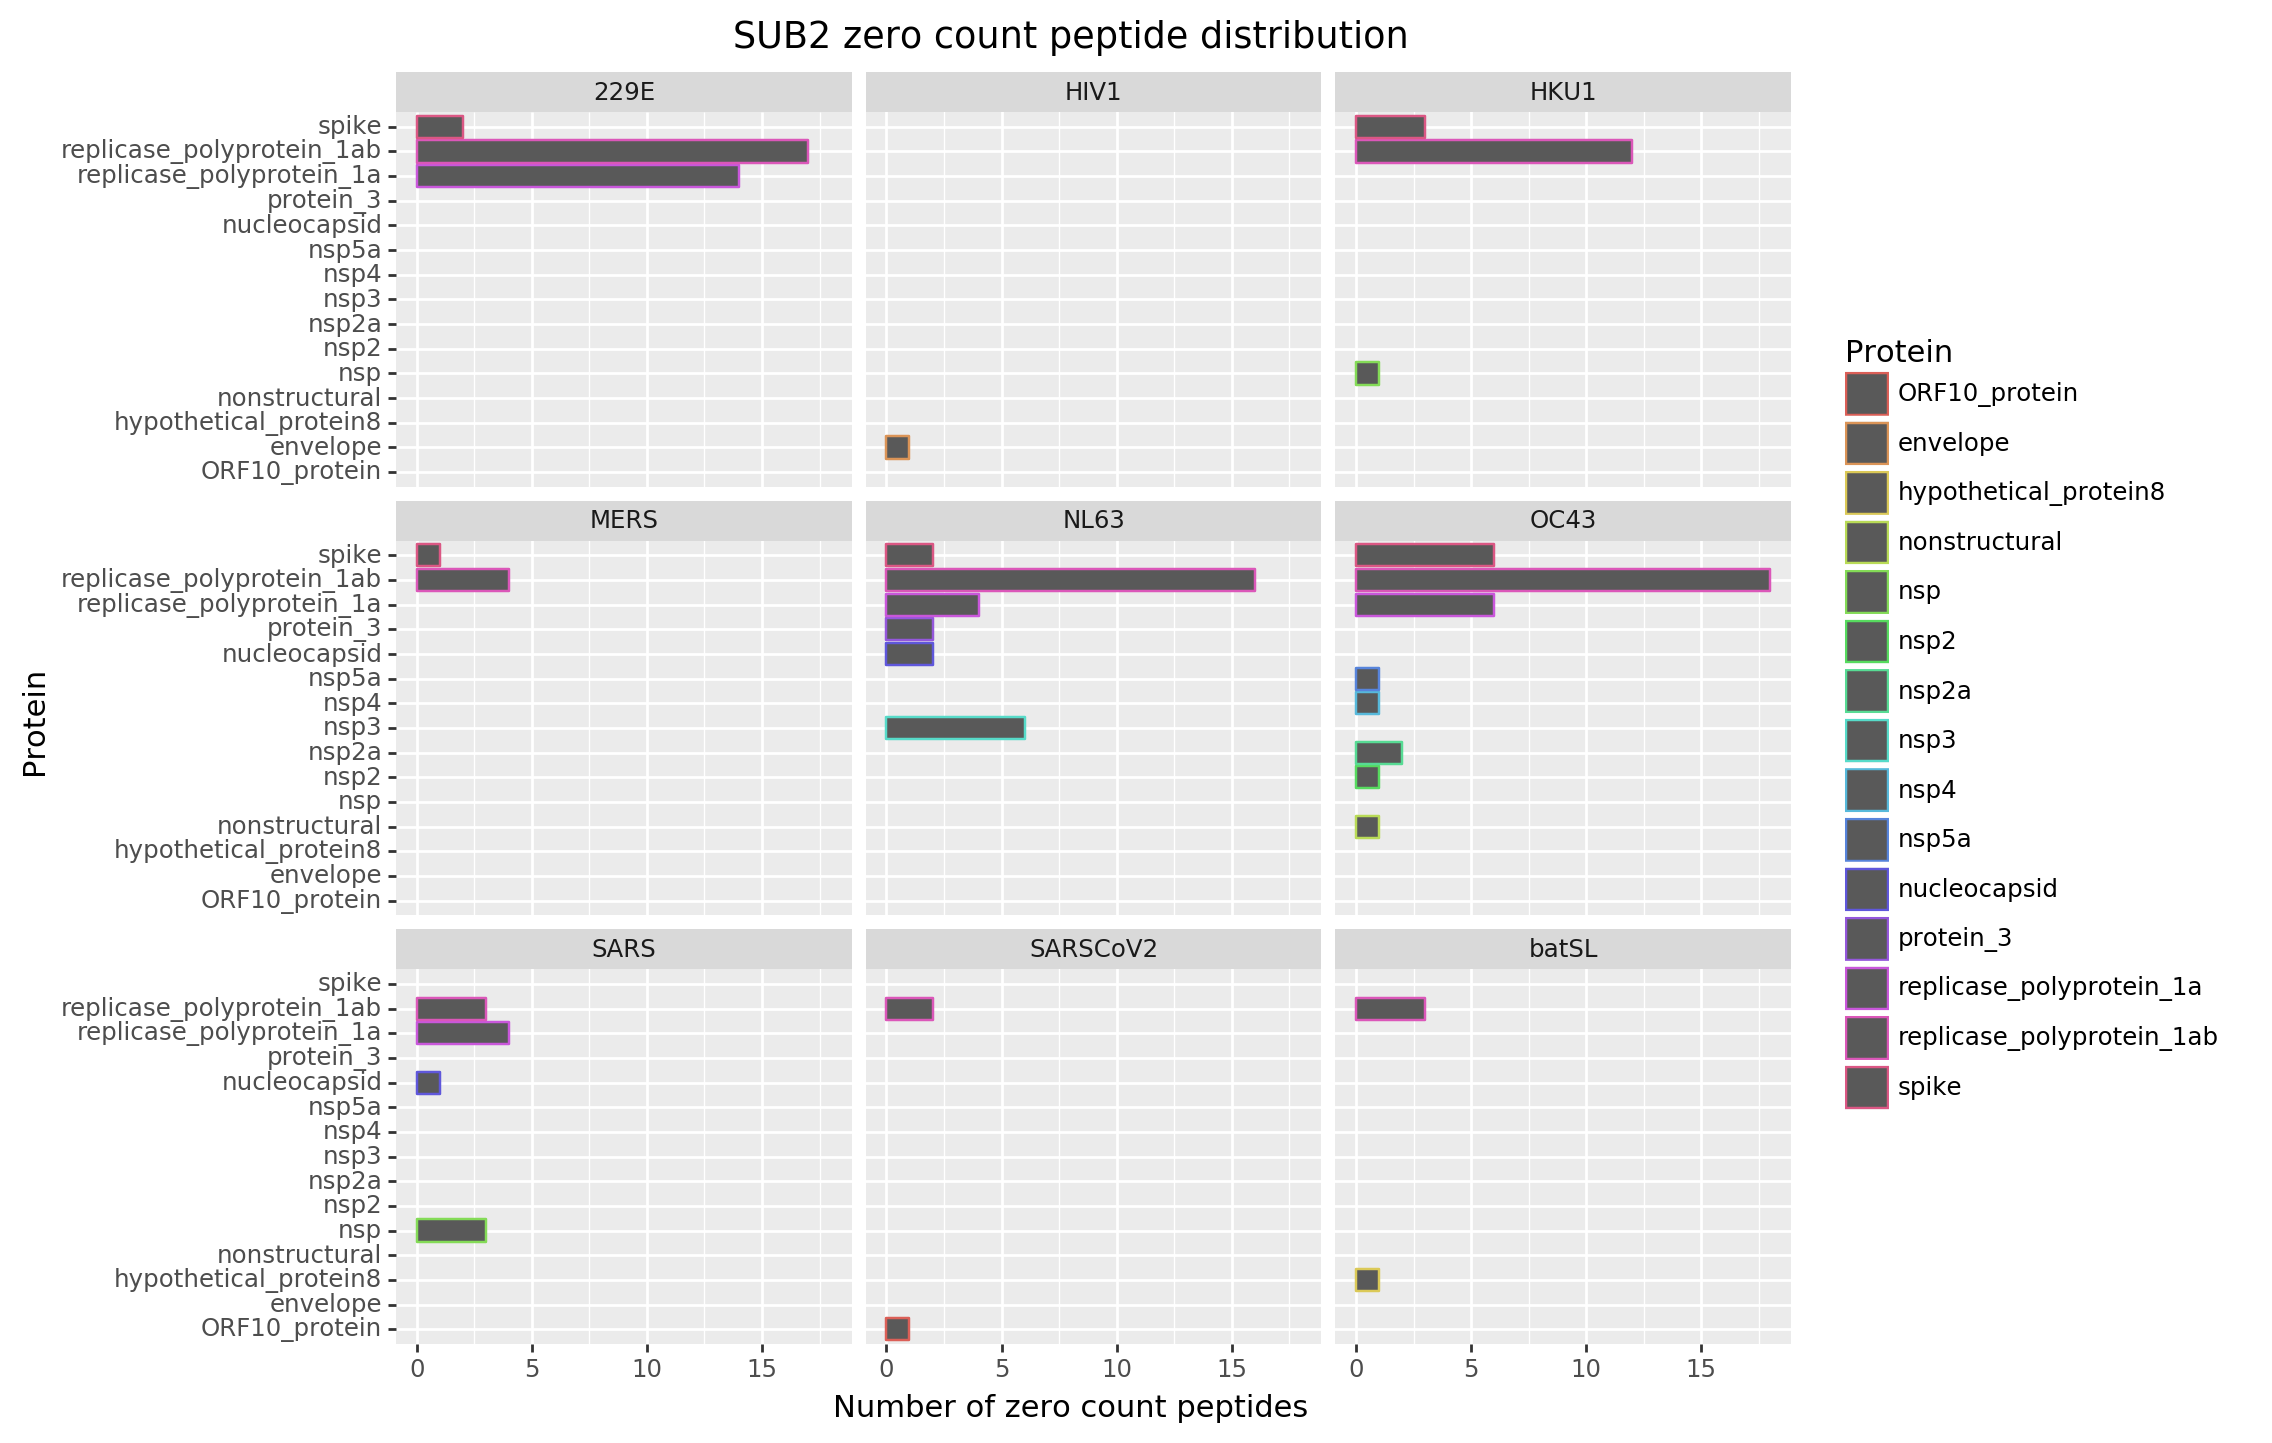

<ggplot: (8787239203837)>

In [122]:
high_quality_lib_sub2 = get_high_quality_controls(xpds, "SUB2")
zero_count_peptides_sub2 = shared_zero_count_peptides(xpds, high_quality_lib_sub2)
zero_count_peptides_sub2_df = xpds.peptide_table.loc[zero_count_peptides_sub2,:].to_pandas()
(
    ggplot(zero_count_peptides_sub2_df)
    + geom_bar(aes(x='Protein', color="Protein"))
    + coord_flip()
    + theme(figure_size=[9,8])
    #+ theme_classic()
    + facet_wrap('~Virus')
    + labs(
     title=f"SUB2 zero count peptide distribution",
     y="Number of zero count peptides",
     x="Protein"
    )
)
